# Generation of time-dependent snapshots

**Aim of this notebook:** generate time-dependent snapshots of the flow over a cylinder.

This notebook implements the solution of the flow over cylinder based on the implementation by J. Dokken on the [FEniCSx tutorials](https://jsdokken.com/dolfinx-tutorial/chapter2/ns_code2.html) and the [IPCS solver for Navier-Stokes](https://github.com/jorgensd/dolfinx_ipcs).

The kinematic viscosity is given by $\nu=\frac{\mu}{\rho}=0.001\,\frac{m^2}{s}$ and the inflow velocity profile is specified as (with $\mathbf{x}=[x,y]^T$)
\begin{equation*}
\begin{split}
\mathbf{u}_{in}(\mathbf{x},t) &= \left[ U \cdot \frac{4\,y(0.41-y)}{0.41^2}, 0 \right]^T\\
U=U(t) &= 1.5\sin(\pi t/8)
\end{split}
\end{equation*}
which has a maximum magnitude of $1.5$ at $y=0.41/2$. 

In [1]:
from IPython.display import clear_output
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm

from petsc4py import PETSc
from dolfinx.io import XDMFFile

from pyforce.tools.backends import LoopProgress

## Mesh generation
The geometry and the domain will be defined using *gmsh* in Python.

In [2]:
from ns import create_dfg2_mesh

mesh, ct, ft, gdim = create_dfg2_mesh(mesh_factor=0.5, save_mesh=True)
clear_output()

# Definition of the markers for the boundaries
bound_markers = dict()
bound_markers['inlet']     = 1
bound_markers['walls']     = 2
bound_markers['outlet']    = 3
bound_markers['obstacle']  = 4

## Physical and discretization parameters
Following the DGF-2 benchmark, we define the physical and discretization parameters.

In [3]:
t = 0
T = 8                       # Final time
dt = 5.00e-4                # Time step size
num_steps = int(T/dt)

params = dict()
params['nu'] = 1e-3
params['dt'] = dt
params['T']  = T

# Define boundary conditions: this class is used to define time dependent inlet
class InletVelocity():
    def __init__(self, t, T):
        self.t = t
        self.T = 8

    def __call__(self, x):
        values = np.zeros((gdim, x.shape[1]),dtype=PETSc.ScalarType)
        values[0] = 4 * x[1] * (0.41 - x[1])/(0.41**2) * 1.5 * np.sin(self.t * np.pi/self.T)
        return values
    
print('The Reynolds number is {:.2f}'.format(1 * 0.1 / params['nu']))

The Reynolds number is 100.00


## Assembling variational forms

The Navier-Stokes equations are discretised using a fractional step method: at first, a tentative velocity is computed and then the incompressibility constraint is enforced through the solution the pressure Poisson problem, in a similar way of the [FEniCSx tutorial](https://jsdokken.com/dolfinx-tutorial/chapter2/ns_code2.html#variational-form).

Three different options have been implemented for the time discretisation of the tentative velocity problem: 

1. *BDF2* = Backward Differentiation Formula of order 2
2. *CN* = Crank-Nicolson
3. *EI* = Euler Implicit

These options have been implemented in `ns.py` and can be selected by changing the value of the variable `time_adv`: in particular, for each step of the fractional step method a proper class has been implemented. For the sake of brevity, the mathematical formulation of each step is not reported here: the CN algorithm is fully explained in [here](https://jsdokken.com/dolfinx-tutorial/chapter2/ns_code2.html#variational-form), whereas the others can be found in numerical analysis textbook such as [Quarteroni, 2014](https://link.springer.com/book/10.1007/978-88-470-5522-3).

In [4]:
from ns import TentativeVelocity, PressureProjection, UpdateVelocity
time_adv = 'BDF2'

# Each class is initialized with the mesh, the cell zones, the face tags, the parameters, the boundary markers and the time advancement scheme.
# TentativeVelocity includes also the InletVelocity class that is used to define the time dependent inlet velocity.

step01 = TentativeVelocity(mesh, ct, ft, params, bound_markers, InletVelocity, time_adv=time_adv)
step01.assembleForm(direct=False)

step02 = PressureProjection(mesh, ct, ft, params, bound_markers, time_adv=time_adv)
step02.assembleForm(direct=False)

step03 = UpdateVelocity(mesh, ct, ft, params, time_adv=time_adv)
step03.assembleForm(direct=False)

### Setting up the tools to compute drag and lift coefficient
The FOM will be validated against the [FEATFLOW dataset](https://wwwold.mathematik.tu-dortmund.de/~featflow/en/benchmarks/cfdbenchmarking/flow/dfg_benchmark2_re100.html) comparing the drag $c_D$ and lift $c_L$ coefficients, defined as

\begin{equation*}
\begin{split}
c_{\text{D}} &= \frac{2}{\rho L U_{mean}^2}\int_{\Gamma_S} \nu \frac{\partial u_{t_S}}{\partial \mathbf{n}}n_y -p n_x~\mathrm{d} s\\
c_{\text{L}} &= -\frac{2}{\rho L U_{mean}^2}\int_{\Gamma_S} \nu \frac{\partial u_{t_S}}{\partial \mathbf{n}}n_x + p n_y~\mathrm{d} s
\end{split}
\end{equation*}
where $u_{t_S}$ is the tangential velocity component at the interface of the obstacle $\partial\Omega_S$, defined as $u_{t_S}=u\cdot (n_y,-n_x)$, $U_{mean}=1$ the average inflow velocity, and $L$ the length of the channel. 

The implementation of these integrals is done in the `ns.py` file within the `DragLift` class, following the code of the [FEniCSx tutorial](https://jsdokken.com/dolfinx-tutorial/chapter2/ns_code2.html#verification-of-the-implementation-compute-known-physical-quantities): an additional parameter is required that is $\rho L U_{mean}^2$, in particular $\rho=1\, kg/m^3$ , $U_{mean}=1\, m/s$ and $L=0.1 \,m^2$ (diameter of the cylinder).

In [5]:
from ns import DragLift

params['rhoLU2'] = 0.1

# The class is initialized with the mesh, the face tags, the parameters and the boundary markers.
get_drag_lift = DragLift(mesh, ft, params, bound_markers['obstacle'])

## Solving the time-dependent problem
The velocity and the pressure are stored, for later usage, in appropriate data structures in a directory named `Snapshots` created by the following code block.

In [6]:
progr_bar = LoopProgress('Solving NS', final = T)

store_snap = True

if store_snap:
    u_xdmf = XDMFFile(mesh.comm, "Snapshots/snaps_u.xdmf", "w")
    p_xdmf = XDMFFile(mesh.comm, "Snapshots/snaps_p.xdmf", "w")

    u_xdmf.write_mesh(mesh)
    p_xdmf.write_mesh(mesh)

LL = 25
kk = 1
time_store = list()

for i in range(num_steps):
    
    # Update current time step
    t += dt
    
    # Tentative velocity
    step01.advance(t)
    
    # Pressure projection
    step02.advance(step01.u_tilde)
    
    if time_adv != 'EI':
        with step01.uOld.vector.localForm() as loc_, step01.u_n.vector.localForm() as loc_n:
            loc_.copy(loc_n)
        
    step03.advance(step01.u_tilde, step02.phi)
    
    step01.pOld.vector.axpy(1, step02.phi.vector)
    step01.pOld.x.scatter_forward()
    
    # Save solution
    if (np.isclose(t, kk * LL * dt)):
        if store_snap:
            u_xdmf.write_function(step03.u_new, t)
            p_xdmf.write_function(step01.pOld, t)
        
        # Compute QoI
        get_drag_lift.compute(t, dt, step03.u_new, step01.pOld)
        
        kk += 1

    # Update old
    with step03.u_new.vector.localForm() as loc_, step01.uOld.vector.localForm() as loc_n:
        loc_.copy(loc_n)
        
    progr_bar.update(dt, percentage=False)
        
if store_snap:
    u_xdmf.close()
    p_xdmf.close()

Solving NS: 8.000 / 8.00 - 0.065 s/it


Store the Quantities of Interest (QoI) in a file, placed in the same directory of the benchmark data, which is in the parent directory of the current one, i.e. `../BenchmarkData`.

In [7]:
import pickle

res = dict()
res['t_u'] = get_drag_lift.t_u
res['t_p'] = get_drag_lift.t_p
res['C_D'] = get_drag_lift.C_D
res['C_L'] = get_drag_lift.C_L
res['dP']  = get_drag_lift.p_diff

pickle.dump(res, open('./../BenchmarkData/QoI_'+time_adv, 'wb'))

### Comparison with benchmark data
The drag and lift coefficients are compared with benchmark data from [DFG2](https://wwwold.mathematik.tu-dortmund.de/~featflow/en/benchmarks/cfdbenchmarking/flow/dfg_benchmark2_re100.html).

This notebook generates the data for a single `time_adv` option, but the user can easily modify the code to generate the data for the other options. In the following, the plot of the drag and lift coefficients reports the results for each case for completeness.

The Benchmark Data have been download from https://github.com/jorgensd/dolfinx-tutorial/blob/main/chapter2.

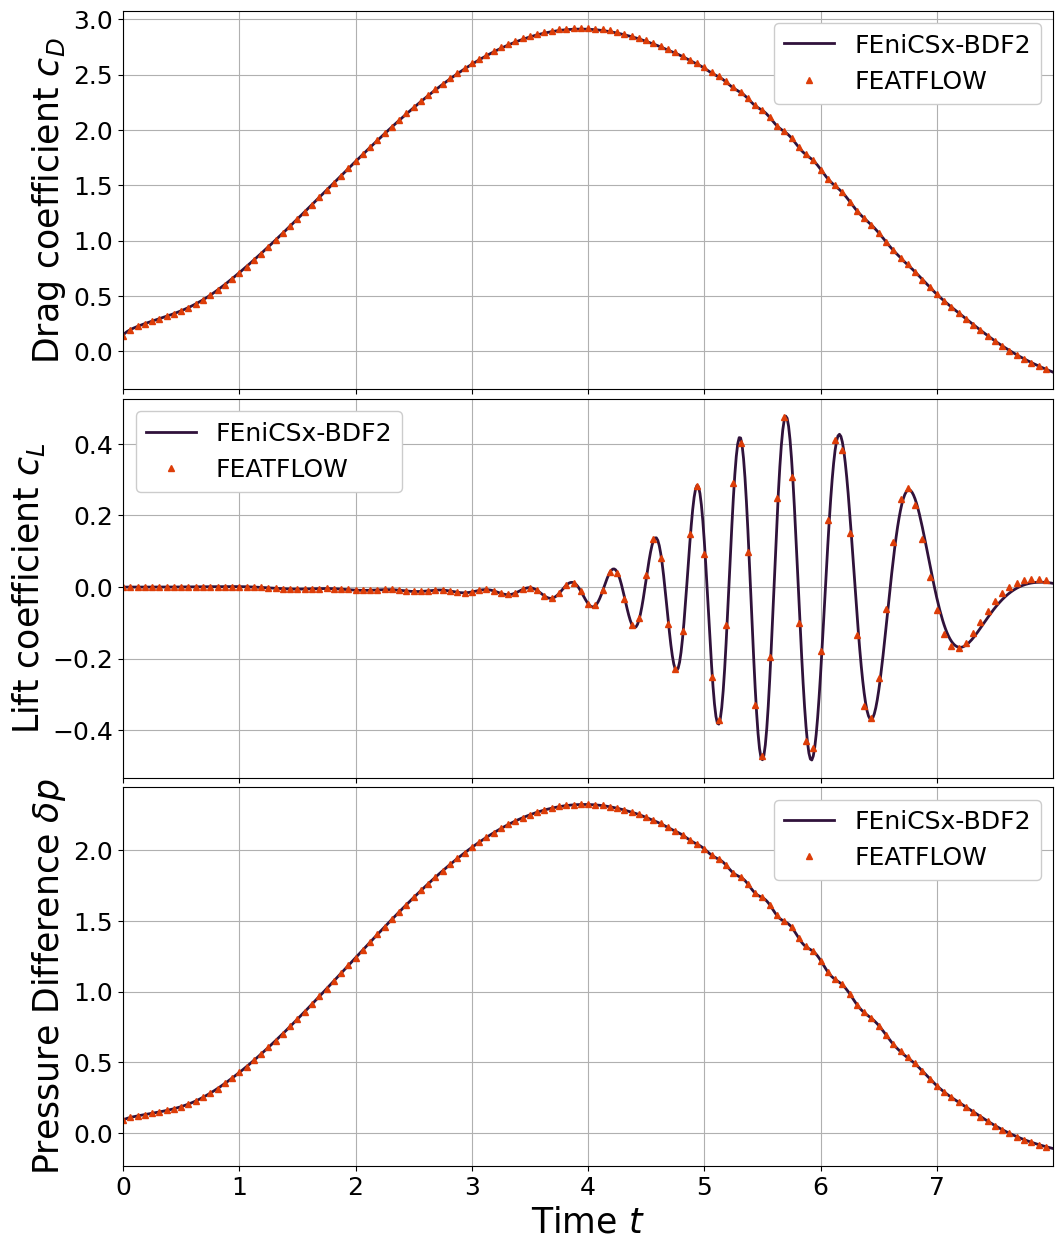

In [8]:
def QoI_plot(QoI, bench_bdforces, ptvalues, time_adv_schemes):
    colors = cm.turbo(np.linspace(0., 0.85, len(time_adv_schemes)+1))
    line_styles = ['-', '--', '-.']

    fig, axs = plt.subplots(3, 1, sharex=True, figsize=(12, 5*3))
    
    for kk in range(len(time_adv_schemes)):
        
        # Drag coefficient
        axs[0].plot(QoI[kk]['t_u'], QoI[kk]['C_D'], color=colors[kk], linestyle=line_styles[kk], label=r"FEniCSx-"+time_adv_schemes[kk], linewidth=2)
        axs[0].plot(bench_bdforces[1:,1], bench_bdforces[1:,3], "^", color=colors[-1], markevery=100, markersize=5, label="FEATFLOW")
        axs[0].set_ylabel(r"Drag coefficient $c_D$", fontsize=25)
        
        # Lift coefficient
        axs[1].plot(QoI[kk]['t_u'], QoI[kk]['C_L'], color=colors[kk], linestyle=line_styles[kk], label=r"FEniCSx-"+time_adv_schemes[kk], linewidth=2)
        axs[1].plot(bench_bdforces[1:,1], bench_bdforces[1:,4], "^", color=colors[-1], markevery=100, markersize=5, label="FEATFLOW")
        axs[1].set_ylabel(r"Lift coefficient $c_L$", fontsize=25)

        # Pressure Difference
        axs[2].plot(QoI[kk]['t_p'], QoI[kk]['dP'], color=colors[kk], linestyle=line_styles[kk], label=r"FEniCSx-"+time_adv_schemes[kk], linewidth=2)
        axs[2].plot(bench_bdforces[1:,1], ptvalues[1:,6]-ptvalues[1:,-1], "^", color=colors[-1], markevery=100, markersize=5, label="FEATFLOW")
        axs[2].set_ylabel(r"Pressure Difference $\delta p$", fontsize=25)

    for ax in axs:
        ax.grid(which='major', linestyle='-')
        ax.grid(which='minor', linestyle='--')
        ax.legend(framealpha=1, fontsize=18)
        ax.set_xlim([0, QoI[kk]['t_p'][-1]])
        ax.tick_params(axis='both', which='major', labelsize=18)
        
    axs[2].set_xlabel(r"Time $t$", fontsize=25)
    fig.subplots_adjust(hspace=0.025)

turek = np.loadtxt("./../BenchmarkData/LaminarNS_DFG2/bdforces_lv4.txt")
turek_p = np.loadtxt("./../BenchmarkData/LaminarNS_DFG2/pointvalues_lv4.txt")

time_adv_schemes = ['BDF2']
# If data have been generated, the same code can be used to compare the time advancement schemes
# time_adv_schemes = ['BDF2', 'CN', 'EI']

QoI_data = [pickle.load(open('./../BenchmarkData/QoI_'+time_adv_schemes[kk], 'rb')) for kk in range(len(time_adv_schemes))]

QoI_plot(QoI_data, turek, turek_p, time_adv_schemes)